In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels

from pandas import DataFrame, Series
from typing import Optional
from datetime import datetime

warnings.filterwarnings("ignore")


In [2]:
URL = (
    "https://course-resources.minerva.edu/uploaded_files/mu/00294342-2873/diabetes.csv"
)

X = "SkinThickness"
Xs = ["SkinThickness", "Glucose", "BloodPressure"]

Y = "BMI"


In [3]:
def preprocess_df(df: DataFrame) -> DataFrame:
    """
    Preprocesses the DataFrame by removing rows with 0 values for the columns
    of interest.
    """

    df = df[(df[X] != 0) & (df[Y] != 0)]
    for x in Xs:
        df = df[df[x] != 0]

    return df


In [4]:
def get_figure_filename(name: str) -> str:
    """Returns a filename for a figure based on the current time and the given name."""

    now = datetime.now()
    return f"figures/{now.strftime('%Y%m%d%H%M%S')}-{name}.png"


In [5]:
df = preprocess_df(pd.read_csv(URL))


In [22]:
df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.516917,121.030075,71.505639,29.182331,114.988722,32.890226,0.502966,31.614662,0.332707
std,3.312036,30.999226,12.310253,10.523878,123.007555,6.881109,0.344546,10.761584,0.471626
min,0.000000,56.000000,24.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.750000,64.000000,22.000000,0.000000,27.875000,0.258750,23.000000,0.000000
50%,2.000000,115.000000,72.000000,29.000000,91.500000,32.800000,0.416000,28.000000,0.000000
75%,5.000000,141.250000,80.000000,36.000000,165.250000,36.900000,0.658500,38.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


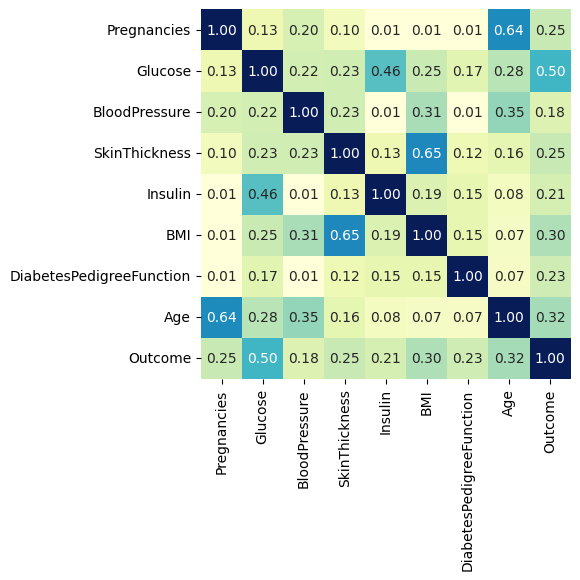

In [7]:
def plot_correlation_matrix(df: DataFrame, name: Optional[str] = None):
    """Plots (and saves) a correlation matrix for the given DataFrame."""

    sns.heatmap(
        df.corr().abs(),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        cbar=False,
        square=True,
    )

    plt.savefig(get_figure_filename(name or "correlation-matrix"), dpi=600)
    plt.show()


plot_correlation_matrix(df)


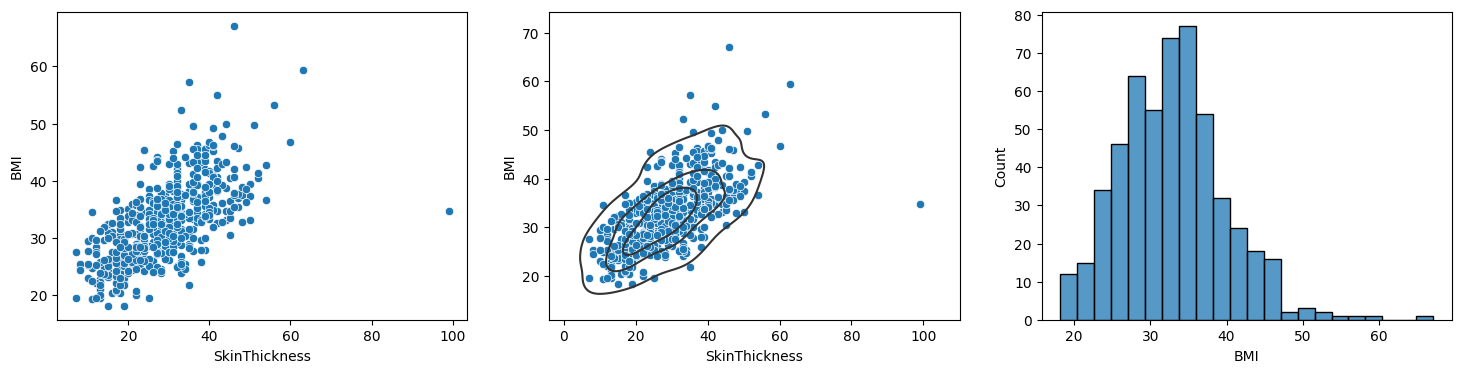

In [8]:
def plot_scatter(x: Series, y: Series, name: Optional[str] = None):
    """Plots (and saves) a scatter plot for the given Series."""

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))

    sns.scatterplot(x=x, y=y, ax=ax1)

    sns.scatterplot(x=x, y=y, ax=ax2)

    # Add a kernel density estimate plot on top of the scatter plot
    sns.kdeplot(x=x, y=y, ax=ax2, levels=4, color=".2")

    sns.histplot(y, ax=ax3)

    plt.savefig(get_figure_filename(name or "scatter"), dpi=600)
    plt.show()


plot_scatter(df[X], df[Y])


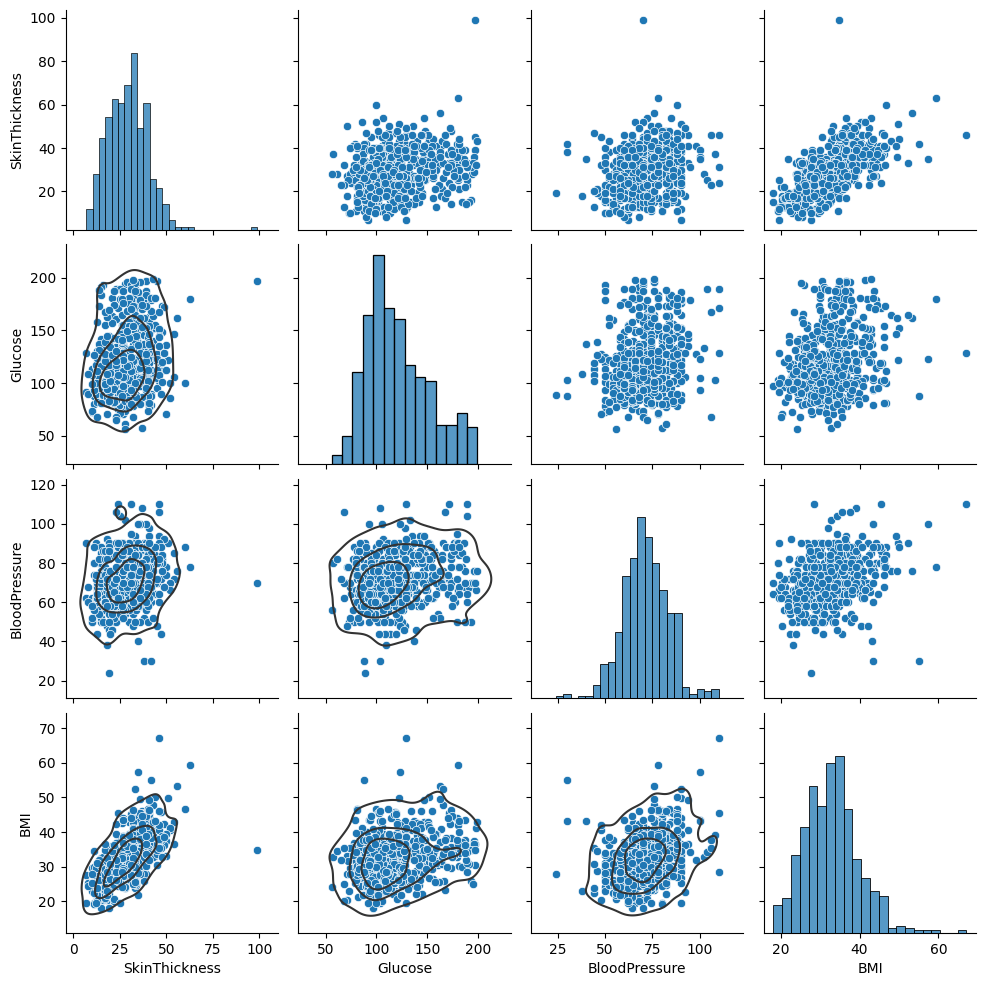

In [9]:
def plot_scatter_matrix(df: DataFrame, name: Optional[str] = None):
    """Plots (and saves) a scatter matrix for the given DataFrame."""

    plot = sns.pairplot(df)
    
    # Add kernel density estimate plots on the scatters in the lower triangle
    plot.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.savefig(get_figure_filename(name or "scatter-matrix"), dpi=600)
    plt.show()


plot_scatter_matrix(df[[*Xs, Y]])


                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     382.5
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           1.60e-64
Time:                        22:03:53   Log-Likelihood:                -1636.0
No. Observations:                 532   AIC:                             3276.
Df Residuals:                     530   BIC:                             3285.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.5367      0.671     30.587

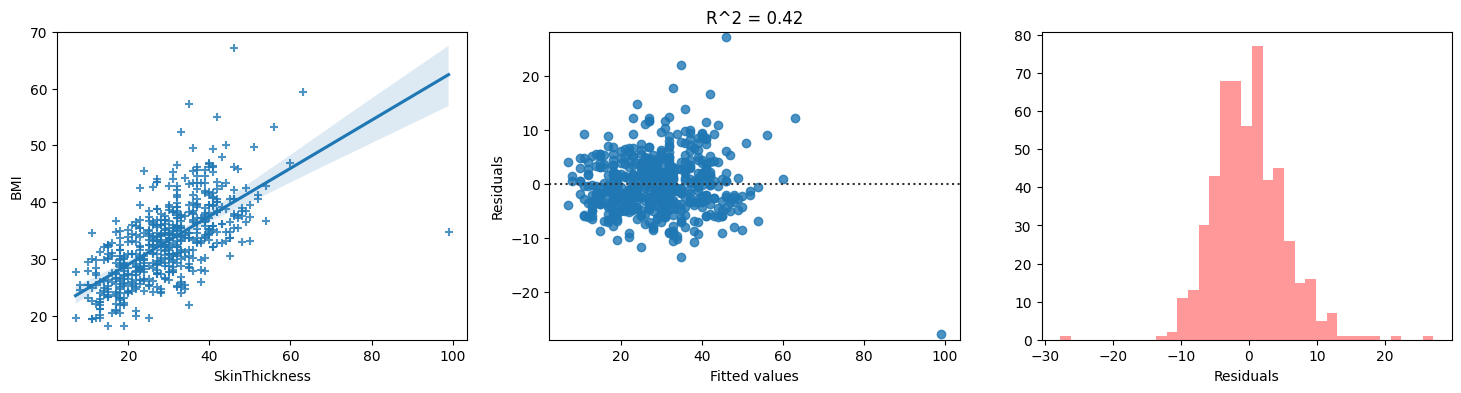

In [10]:
def simple_regression(
    x: Series,
    y: Series,
    plot: bool = False,
    plot_name: Optional[str] = None,
    summary: bool = False,
) -> tuple[float, float, float]:
    """Performs a simple regression on the given Series and returns the R^2, b_0, and b_1."""

    _x = statsmodels.add_constant(x)
    model = statsmodels.OLS(y, _x)
    results = model.fit()

    if summary:
        print(results.summary())

    r_squared = results.rsquared
    b_0, b_1 = results.params

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))

        # ax1: scatter
        sns.regplot(x=x, y=y, marker="+", ax=ax1)

        # ax2: residuals
        sns.residplot(x=x, y=y, ax=ax2)
        ax2.set(
            ylabel="Residuals",
            xlabel="Fitted values",
            title=f"R^2 = {r_squared:.2f}",
            ylim=(min(results.resid) - 1, max(results.resid) + 1),
        )

        # ax3: histogram
        sns.distplot(results.resid, kde=False, axlabel="Residuals", color="red", ax=ax3)

        plt.savefig(get_figure_filename(plot_name or "simple-regression"), dpi=600)
        plt.show()

    return r_squared, b_0, b_1


r_squared, b_0, b_1 = simple_regression(df[X], df[Y], plot=True, summary=True)


                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     145.2
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           1.29e-68
Time:                        22:03:55   Log-Likelihood:                -1620.4
No. Observations:                 532   AIC:                             3249.
Df Residuals:                     528   BIC:                             3266.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.2175      1.454      9.089

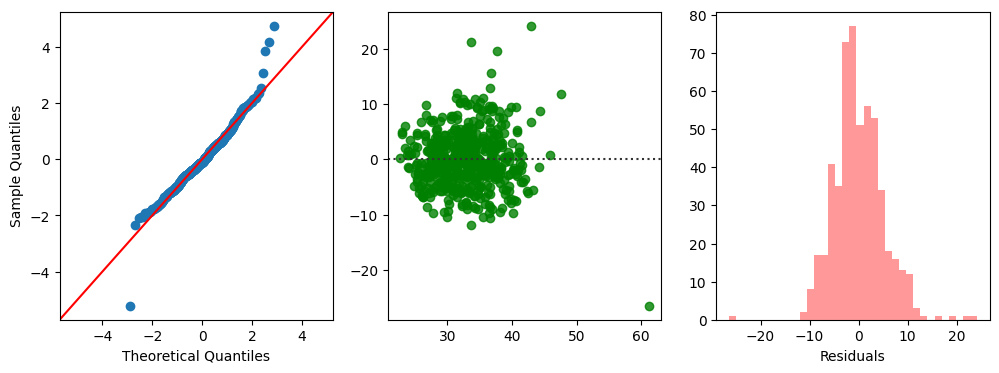

In [11]:
def multiple_regression(
    x,
    y: Series,
    plot: bool = False,
    plot_name: Optional[str] = None,
    summary: bool = False,
) -> tuple[float, float, list[float]]:
    """Performs a multiple regression on the given Series and returns the R^2, b_0, and b_1."""

    x = statsmodels.add_constant(x)
    model = statsmodels.OLS(y, x)
    results = model.fit()

    if summary:
        print(results.summary())

    residuals = results.resid
    r_squared = results.rsquared
    b_0, *b = results.params

    y_hat = results.predict()

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))

        # ax1: qq
        statsmodels.qqplot(residuals, fit=True, line="45", ax=ax1)
        ax1.set(
            # xlabel="Theoretical Quantiles",
            # ylabel="Sample Quantiles",
            # title='Normal Probability ("QQ") Plot for Residuals',
        )

        # ax2: residual
        sns.residplot(x=y_hat, y=residuals, color="green", ax=ax2)
        ax2.set(
            # xlabel="Fitted values for y",
            # ylabel="Residuals",
            # title="Residuals vs Fitted values",
        )

        # ax3: histogram
        sns.distplot(residuals, kde=False, axlabel="Residuals", color="red", ax=ax3)
        ax3.set()

        plt.savefig(get_figure_filename(plot_name or "multiple-regression"), dpi=600)
        plt.show()

    return r_squared, b_0, b


r_squared, b_0, b = multiple_regression(df[Xs], df[Y], plot=True, summary=True)


In [12]:
def forward_selection(
    df: DataFrame,
    xs: list[str],
    y: str,
) -> tuple[list[str], float, float, list[float]]:
    """Performs a forward selection on the given DataFrame and returns the best R^2, b_0, and b_1."""

    best_r_squared = 0
    best_xs = None
    best_b_0 = None
    best_b = None

    for i in range(1, len(xs) + 1):
        for _xs in itertools.combinations(xs, i):
            r_squared, b_0, b = multiple_regression(df[list(_xs)], df[y])
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_xs = _xs
                best_b_0 = b_0
                best_b = b

    return best_xs, best_r_squared, best_b_0, best_b  # type: ignore


columns: list[str] = list(df.columns)  # type: ignore
columns.remove(Y)

xs, r_squared, b_0, b = forward_selection(df, columns, Y)

print(f"{xs=}", f"{r_squared=:.2f}")


xs=('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Outcome') r_squared=0.49


In [13]:
def standard_error(x: Series, y: Series, r_squared: float, ddof=1) -> float:
    """Calculates the standard error of the regression."""

    n = len(x)
    s_x = x.std(ddof=ddof)
    s_y = y.std(ddof=ddof)
    return (s_y / s_x) * np.sqrt((1 - r_squared) / (n - 2))


In [14]:
def p_value(x: Series, y: Series, beta_1: float, tails: int = 2) -> float:
    """Calculates the p-value of the regression."""

    r_squared, b_0, b_1 = simple_regression(x, y)
    SE_b_1 = standard_error(x, y, r_squared)

    t = (b_1 - beta_1) / SE_b_1
    p: float = stats.t.sf(np.abs(t), len(x) - 2) * tails  # type: ignore

    return p


p = p_value(
    df[X],
    df[Y],
    0,
    tails=2,
)
print(f"{p=}")


p=1.596266229659147e-64


In [15]:
def confidence_interval(
    x: Series, y: Series, alpha: float = 0.05
) -> tuple[float, float]:
    """Calculates the confidence interval of the regression."""

    r_squared, b_0, b_1 = simple_regression(x, y)
    SE_b_1 = standard_error(x, y, r_squared)

    t: float = stats.t.ppf(1 - alpha / 2, len(x) - 2)  # type: ignore

    lower = b_1 - t * SE_b_1
    upper = b_1 + t * SE_b_1

    return lower, upper


ALPHA = 0.05
lower, upper = confidence_interval(df[X], df[Y], alpha=ALPHA)
print(f"{(1-ALPHA)*100:.2f}% [{lower=}, {upper=}]")


95.00% [lower=0.380799338132206, upper=0.4658437007066819]
